<a href="https://colab.research.google.com/github/miam-bonbon/assignment-computer-vision/blob/main/assignment_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading the dataset

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd

/content


In [3]:
%cd drive/MyDrive/assignment-computer-vision
!ls -l

/content/drive/MyDrive/assignment-computer-vision
total 73436
drwx------ 2 root root     4096 Nov 23 13:30 data
drwx------ 2 root root     4096 Nov 26 16:28 datasets
drwx------ 2 root root     4096 Nov 26 15:35 fruit-detection-yolov5
-rw------- 1 root root   363112 Nov 26 11:53 model.png
-rw------- 1 root root     7733 Nov 23 13:33 plot_functions.py
drwx------ 2 root root     4096 Nov 23 13:43 __pycache__
drwx------ 2 root root     4096 Nov 26 06:52 raw_test_ds_one_banana_only_saved
drwx------ 2 root root     4096 Nov 25 19:35 raw_test_ds_saved
drwx------ 2 root root     4096 Nov 26 06:52 raw_train_ds_one_banana_only_saved
drwx------ 2 root root     4096 Nov 24 19:18 raw_train_ds_saved
drwx------ 2 root root     4096 Nov 26 06:52 raw_validation_ds_one_banana_only_saved
drwx------ 2 root root     4096 Nov 24 19:19 raw_validation_ds_saved
-rw------- 1 root root  5613764 Nov 26 16:30 yolo11n.pt
-rw------- 1 root root 50589507 Nov 26 20:24 yolov5mu.pt
-rw------- 1 root root 18581255 Nov 26

In [4]:
%%capture

# %load_ext autoreload
# %autoreload 2
import os
import glob
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm.auto as tqdm

import tensorflow as tf

# from sklearn.model_selection import train_test_split

class print_style:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [5]:
import plot_functions

In [6]:
!nvidia-smi
tf.config.list_physical_devices('GPU')

Fri Nov 29 09:44:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [78]:
# Dataset configuration
base_path = 'data'
num_classes = 2
input_size = 244

recreate_dataset = False # we load from drive

In [8]:
# Prepare for further processing
# Train
train_image_dir = os.path.join(base_path, 'train')
train_annotation_file = os.path.join(base_path, 'train/_annotations.csv')

if not os.path.exists(train_annotation_file):
    print(f"Error: Annotation file not found at {train_annotation_file}")

train_annotations = pd.read_csv(train_annotation_file)
train_image_files = glob.glob(os.path.join(train_image_dir, '*.jpg'))

# TEst
test_image_dir = os.path.join(base_path, 'test')
test_annotation_file = os.path.join(base_path, 'test/_annotations.csv')

if not os.path.exists(test_annotation_file):
    print(f"Error: Annotation file not found at {test_annotation_file}")

test_annotations = pd.read_csv(test_annotation_file)
test_image_files = glob.glob(os.path.join(test_image_dir, '*.jpg'))

# Validation
validation_image_dir = os.path.join(base_path, 'valid')
validation_annotation_file = os.path.join(base_path, 'valid/_annotations.csv')

if not os.path.exists(validation_annotation_file):
    print(f"Error: Annotation file not found at {validation_annotation_file}")

validation_annotations = pd.read_csv(validation_annotation_file)
validation_image_files = glob.glob(os.path.join(validation_image_dir, '*.jpg'))

In [9]:
# Get all boxes for an image

def get_boxes_for_image(filename, annotations):
    """
    Gets all boxes for a specific image from the annotations DataFrame.

    Args:
        filename: The name of the image file.
        annotations: The pandas DataFrame containing the annotations.

    Returns:
        A dictionary where keys are box indices and values are dictionaries
        containing 'xmin', 'ymin', 'xmax', 'ymax', and 'class' for each box.
        Returns an empty dictionary if no boxes are found for the image.
    """
    image_annotations = annotations[annotations['filename'] == filename]
    boxes_dict = {}
    for index, row in image_annotations.iterrows():
        boxes_dict[index] = {
            'box': row[['xmin', 'ymin', 'xmax', 'ymax']].values,
            'label': row['class']
        }
    return boxes_dict

In [10]:
# A function for displaying an image with parameters image and boxes (each box has a label)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_boxes(plt_img, boxes):
    """Displays an image with bounding boxes and labels.

    Args:
        image_path: Path to the image file.
        boxes: A list of dictionaries, where each dictionary represents a box
               and contains 'xmin', 'ymin', 'xmax', 'ymax', and 'label' keys.
    """
    try:
        boxes = list(boxes.values())
        fig, ax = plt.subplots(1)
        ax.imshow(plt_img)

        for box in boxes:
            xmin = box['box'][0]
            ymin = box['box'][1]
            xmax = box['box'][2]
            ymax = box['box'][3]
            label = box['label']

            rect = patches.Rectangle((xmin, ymin),
                                     xmax - xmin,
                                     ymax - ymin,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Add the label to the box
            ax.text(xmin, ymin, label, color='r', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

        plt.show()

    except KeyError as e:
        print(f"Error: Missing key in box dictionary: {e}")

In [11]:
# # Show an image from train_annotations using display_image_with_boxes

# # The first image file is at index 0
# first_image_path = train_image_files[0]
# first_filename = os.path.basename(first_image_path)
# first_plt_img = plt.imread(first_image_path)
# first_boxes = get_boxes_for_image(first_filename, train_annotations)
# # print(first_boxes)

# # Display the image with bounding boxes using the function
# display_image_with_boxes(first_plt_img, first_boxes)

In [12]:
import cv2 as cv
import numpy as np

def _resize_image_and_boxes(image, boxes, new_width, new_height):
    """Resizes the image and adjusts the bounding boxes accordingly."""
    # Get the original height and width using the 'shape' attribute
    original_height, original_width = image.shape[0], image.shape[1]

    # Resize using OpenCV
    resized_image = cv.resize(image, (new_width, new_height))

    # Adjust bounding boxes and maintain the original format
    resized_boxes = {}
    for box_index, box_data in boxes.items():
      # print(box_data['box'])
      xmin, ymin, xmax, ymax = box_data['box']
      xmin = int(xmin * new_width / original_width)
      ymin = int(ymin * new_height / original_height)
      xmax = int(xmax * new_width / original_width)
      ymax = int(ymax * new_height / original_height)

      # Ensure boxes stay within image bounds after resizing
      xmin = max(0, min(xmin, new_width - 1))
      ymin = max(0, min(ymin, new_height - 1))
      xmax = max(0, min(xmax, new_width - 1))
      ymax = max(0, min(ymax, new_height - 1))

      # Store the resized box in the same format as the input 'boxes'
      resized_boxes[box_index] = {
          'box': np.array([xmin, ymin, xmax, ymax]),
          'label': box_data['label']
      }

    return resized_image, resized_boxes

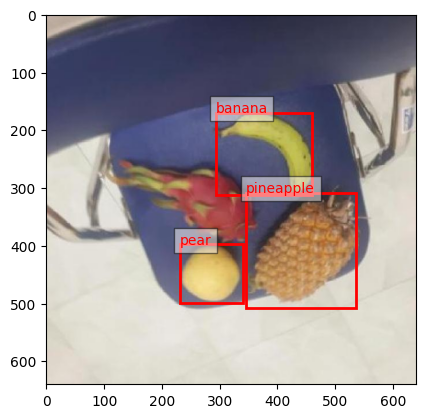

{5109: {'box': array([346, 308, 536, 508], dtype=object), 'label': 'pineapple'}, 5110: {'box': array([231, 397, 340, 498], dtype=object), 'label': 'pear'}, 5111: {'box': array([293, 169, 460, 312], dtype=object), 'label': 'banana'}}
{5109: {'box': array([131, 117, 204, 193]), 'label': 'pineapple'}, 5110: {'box': array([ 88, 151, 129, 189]), 'label': 'pear'}, 5111: {'box': array([111,  64, 175, 118]), 'label': 'banana'}}


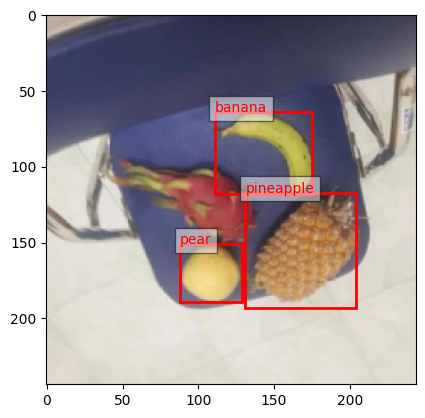

In [13]:
# Let's resize our first image using _resize_image_and_boxes

# The first image file is at index 0
first_image_path = train_image_files[0]
first_filename = os.path.basename(first_image_path)
first_plt_img = plt.imread(first_image_path)
first_boxes = get_boxes_for_image(first_filename, train_annotations)

# Display the image with bounding boxes using the function
display_image_with_boxes(first_plt_img, first_boxes)

# Resize
resized_image, resized_boxes = _resize_image_and_boxes(first_plt_img, first_boxes, input_size, input_size)

# Print the resized boxes
print(first_boxes)
print(resized_boxes)

# Display the resized image with the adjusted bounding boxes:
display_image_with_boxes(resized_image, resized_boxes)

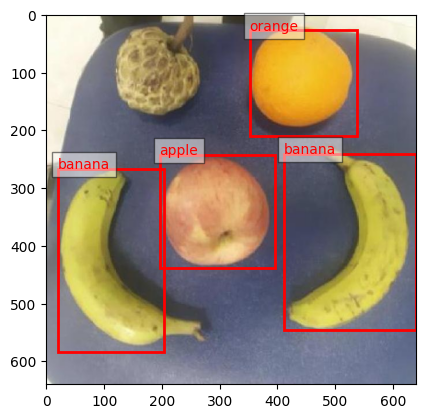

{3679: {'box': array([196, 242, 396, 439], dtype=object), 'label': 'apple'}, 3680: {'box': array([20, 266, 204, 583], dtype=object), 'label': 'banana'}, 3681: {'box': array([411, 240, 640, 545], dtype=object), 'label': 'banana'}, 3682: {'box': array([352, 26, 537, 210], dtype=object), 'label': 'orange'}}
{3679: {'box': array([ 74,  92, 150, 167]), 'label': 'apple'}, 3680: {'box': array([  7, 101,  77, 222]), 'label': 'banana'}, 3681: {'box': array([156,  91, 243, 207]), 'label': 'banana'}, 3682: {'box': array([134,   9, 204,  80]), 'label': 'orange'}}


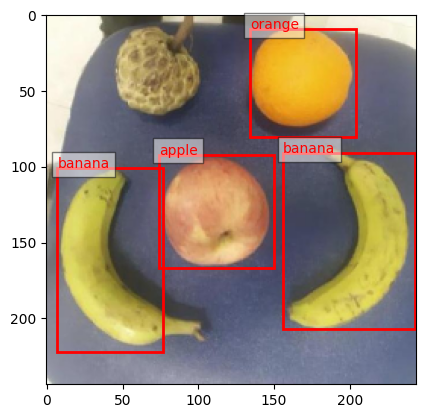

In [14]:
# Another random example
x = random.randint(0, len(train_image_files))

# Image file is at index x
random_image_path = train_image_files[x]
random_filename = os.path.basename(random_image_path)
random_plt_img = plt.imread(random_image_path)
random_boxes = get_boxes_for_image(random_filename, train_annotations)

# Display the image with bounding boxes using the function
display_image_with_boxes(random_plt_img, random_boxes)

# Resize
resized_image, resized_boxes = _resize_image_and_boxes(random_plt_img, random_boxes, input_size, input_size)

# Print the resized boxes
print(random_boxes)
print(resized_boxes)

# Display the resized image with the adjusted bounding boxes:
display_image_with_boxes(resized_image, resized_boxes)

In [15]:
import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

import tensorflow as tf
print(tf.__version__)

2.17.1


## Data preparation

This is where the magic happens - we prepare the data for our model.

### Key points:<br/>
**Adding the Channel Dimension:** If your image data is grayscale, it might initially only have three dimensions (batch size, height, width). Using np.expand_dims(X, axis=3) adds a fourth dimension to represent the channel, even if it's just a single grayscale channel.

**Why it's Important**

Compatibility with CNN Layers: CNN layers are designed to operate on multi-channel data. By adding the channel dimension, you ensure that your data is compatible with these layers.
Flexibility: Even if you're currently working with grayscale images, adding the channel dimension allows you to easily switch to using color images in the future without having to significantly modify your code.

In [16]:
# # prompt: please check for filenames without a label banana

# # Iterate through the annotations and find filenames without 'banana' label
# filenames_without_banana = []
# for filename in set(train_annotations['filename']):
#     boxes = get_boxes_for_image(filename, train_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana.append(filename)
#     else:
#       filenames_without_banana.append(filename)

# print(f"Filenames without 'banana' label in training set: {filenames_without_banana}")

# #Repeat for test and validation sets
# filenames_without_banana_test = []
# for filename in set(test_annotations['filename']):
#     boxes = get_boxes_for_image(filename, test_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana_test.append(filename)
#     else:
#       filenames_without_banana_test.append(filename)

# print(f"Filenames without 'banana' label in test set: {filenames_without_banana_test}")

# filenames_without_banana_validation = []
# for filename in set(validation_annotations['filename']):
#     boxes = get_boxes_for_image(filename, validation_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana_validation.append(filename)
#     else:
#       filenames_without_banana_validation.append(filename)

# print(f"Filenames without 'banana' label in validation set: {filenames_without_banana_validation}")

In [19]:
def data_load(image_files, annotations):
    X = []
    Y = []

    for image_file in image_files:
        img = cv.imread(os.path.join(image_file), cv.IMREAD_GRAYSCALE)
        boxes = get_boxes_for_image(os.path.basename(image_file), annotations)

        # resize everything
        img, boxes = _resize_image_and_boxes(img, boxes, input_size, input_size)

        # Check if a banana box exists
        banana_box_found = False
        for box_data in boxes.values():
            if box_data['label'] == 'banana':
                banana_box_found = True
                label = 1
                box = np.array(box_data['box'], dtype=float)
                break  # Stop searching after finding the first banana box

        # Handle images with no banana box
        if not banana_box_found:
            label = 0  # Set label to 0 for "no banana"
            box = np.array([0, 0, 0, 0], dtype=float)  # Create a dummy bounding box

        # resize_img, boxes = _resize_image_and_boxes(img, boxes, input_size, input_size)
        # print(boxes)
        # return
        img = img.astype(float) / 255.
        # print(img)
        # print(box)
        # we already have a float array
        box = np.asarray(box, dtype=float)
        # we wait with normalizing the bounding boxes
        # box = box / input_size
        # print(box)
        # box = np.append(box, label)
        label = np.append(box, label)
        # print(label)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    X = np.expand_dims(X, axis=3)
    Y = np.array(Y)
    # print(X)
    # print(Y)

    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [103]:
if recreate_dataset:
  print('recreating ds')
  raw_train_ds = data_load(train_image_files, train_annotations)
  raw_validation_ds = data_load(validation_image_files, validation_annotations)
  raw_test_ds = data_load(test_image_files, test_annotations)
else:
  # load from drive
  print('loading from drive')
  raw_train_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_one_banana_only_saved')
  raw_validation_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_one_banana_only_saved')
  raw_test_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_one_banana_only_saved')

  # raw_train_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved')
  # raw_validation_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved')
  # raw_test_ds = tf.data.Dataset.load('/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved')

loading from drive


In [80]:
!pwd

/content/drive/MyDrive/assignment-computer-vision


In [81]:
# tf.data.Dataset.save(raw_train_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved')
# tf.data.Dataset.save(raw_validation_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved')
# tf.data.Dataset.save(raw_test_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved')

# tf.data.Dataset.save(raw_train_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_train_ds_saved_long_run')
# tf.data.Dataset.save(raw_validation_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_validation_ds_saved_long_run')
# tf.data.Dataset.save(raw_test_ds, '/content/drive/MyDrive/assignment-computer-vision/raw_test_ds_saved_long_run')

In [23]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [104]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [105]:
train_ds = tune_training_ds(raw_train_ds)

In [106]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_image_files) // 4)
    # dataset = dataset.repeat()
    return dataset

In [107]:
validation_ds = tune_validation_ds(raw_validation_ds)

In [108]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(test_image_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [109]:
test_ds = tune_test_ds(raw_test_ds)

### Dataset ispection

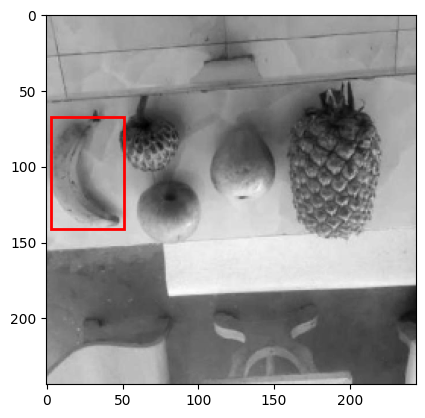

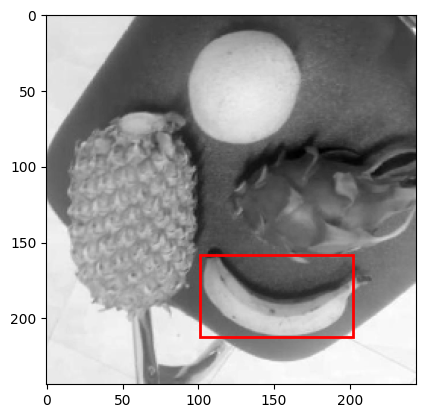

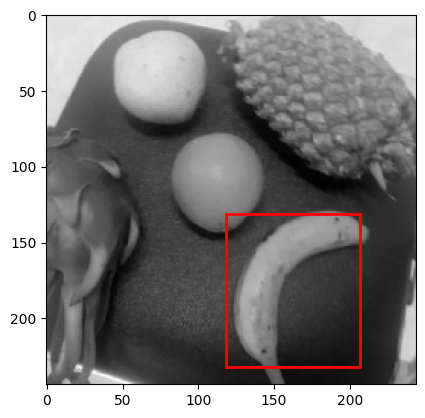

In [110]:
# Inspect the first image from the training_ds with boxes

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming 'train_ds' is your TensorFlow dataset and the first element is available
for image, (label, box) in train_ds.take(3):
    # Convert the image to a NumPy array and remove the batch dimension
    image = image.numpy()[0, :, :]  # Assuming grayscale image and removing channel dim

    # print(label, box)

    # Accessing the bounding box coordinates and label
    xmin = box[0][0].numpy()
    ymin = box[0][1].numpy()
    xmax = box[0][2].numpy()
    ymax = box[0][3].numpy()
    # print(xmin, ymin, xmax, ymax)
    label = label[0].numpy()
    # print(label)


    # Create the plot
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')  # Display grayscale image

    # Create a rectangle patch
    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Display the plot
    plt.show()

## The model

We are building a object detector, our model has two heads: one to classify the object type (or label or class) and other head to output the object bounding box.

In [111]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01), # L2 regularization
                              input_shape=(input_size, input_size, 1))(inputs)

    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # L2 regularization
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x) # L2 regularization
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(64, activation='relu'
  , kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='sigmoid', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units=4, name = 'regressor_head')(inputs)

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    # model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    #           loss = {'classifier_head' : 'binary_crossentropy', 'regressor_head' : 'mse' },
    #           metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.007),
              loss = {'classifier_head' : 'binary_crossentropy', 'regressor_head' : 'mse' },
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

In [112]:
model = build_model(tf.keras.Input(shape=(input_size, input_size, 1)))

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 244, 244, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 242, 242, 16)   │            160 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_42 (Dropout)      │ (None, 242, 242, 16)   │              0 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_42      │ (None, 121, 121, 16)   │              0 │ dropout_42[0][0]       │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 119, 119, 32)   │          4,640 │ average_pooling2d_42[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_43 (Dropout)      │ (None, 119, 119, 32)   │              0 │ conv2d_43[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_43      │ (None, 59, 59, 32)     │              0 │ dropout_43[0][0]       │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 57, 57, 64)     │         18,496 │ average_pooling2d_43[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_44 (Dropout)      │ (None, 57, 57, 64)     │              0 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_44      │ (None, 28, 28, 64)     │              0 │ dropout_44[0][0]       │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_14 (Flatten)      │ (None, 50176)          │              0 │ average_pooling2d_44[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 64)             │      3,211,328 │ flatten_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier_head (Dense)   │ (None, 2)              │            130 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regressor_head (Dense)    │ (None, 4)              │            260 │ dense_14[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

We keep the model small for now:

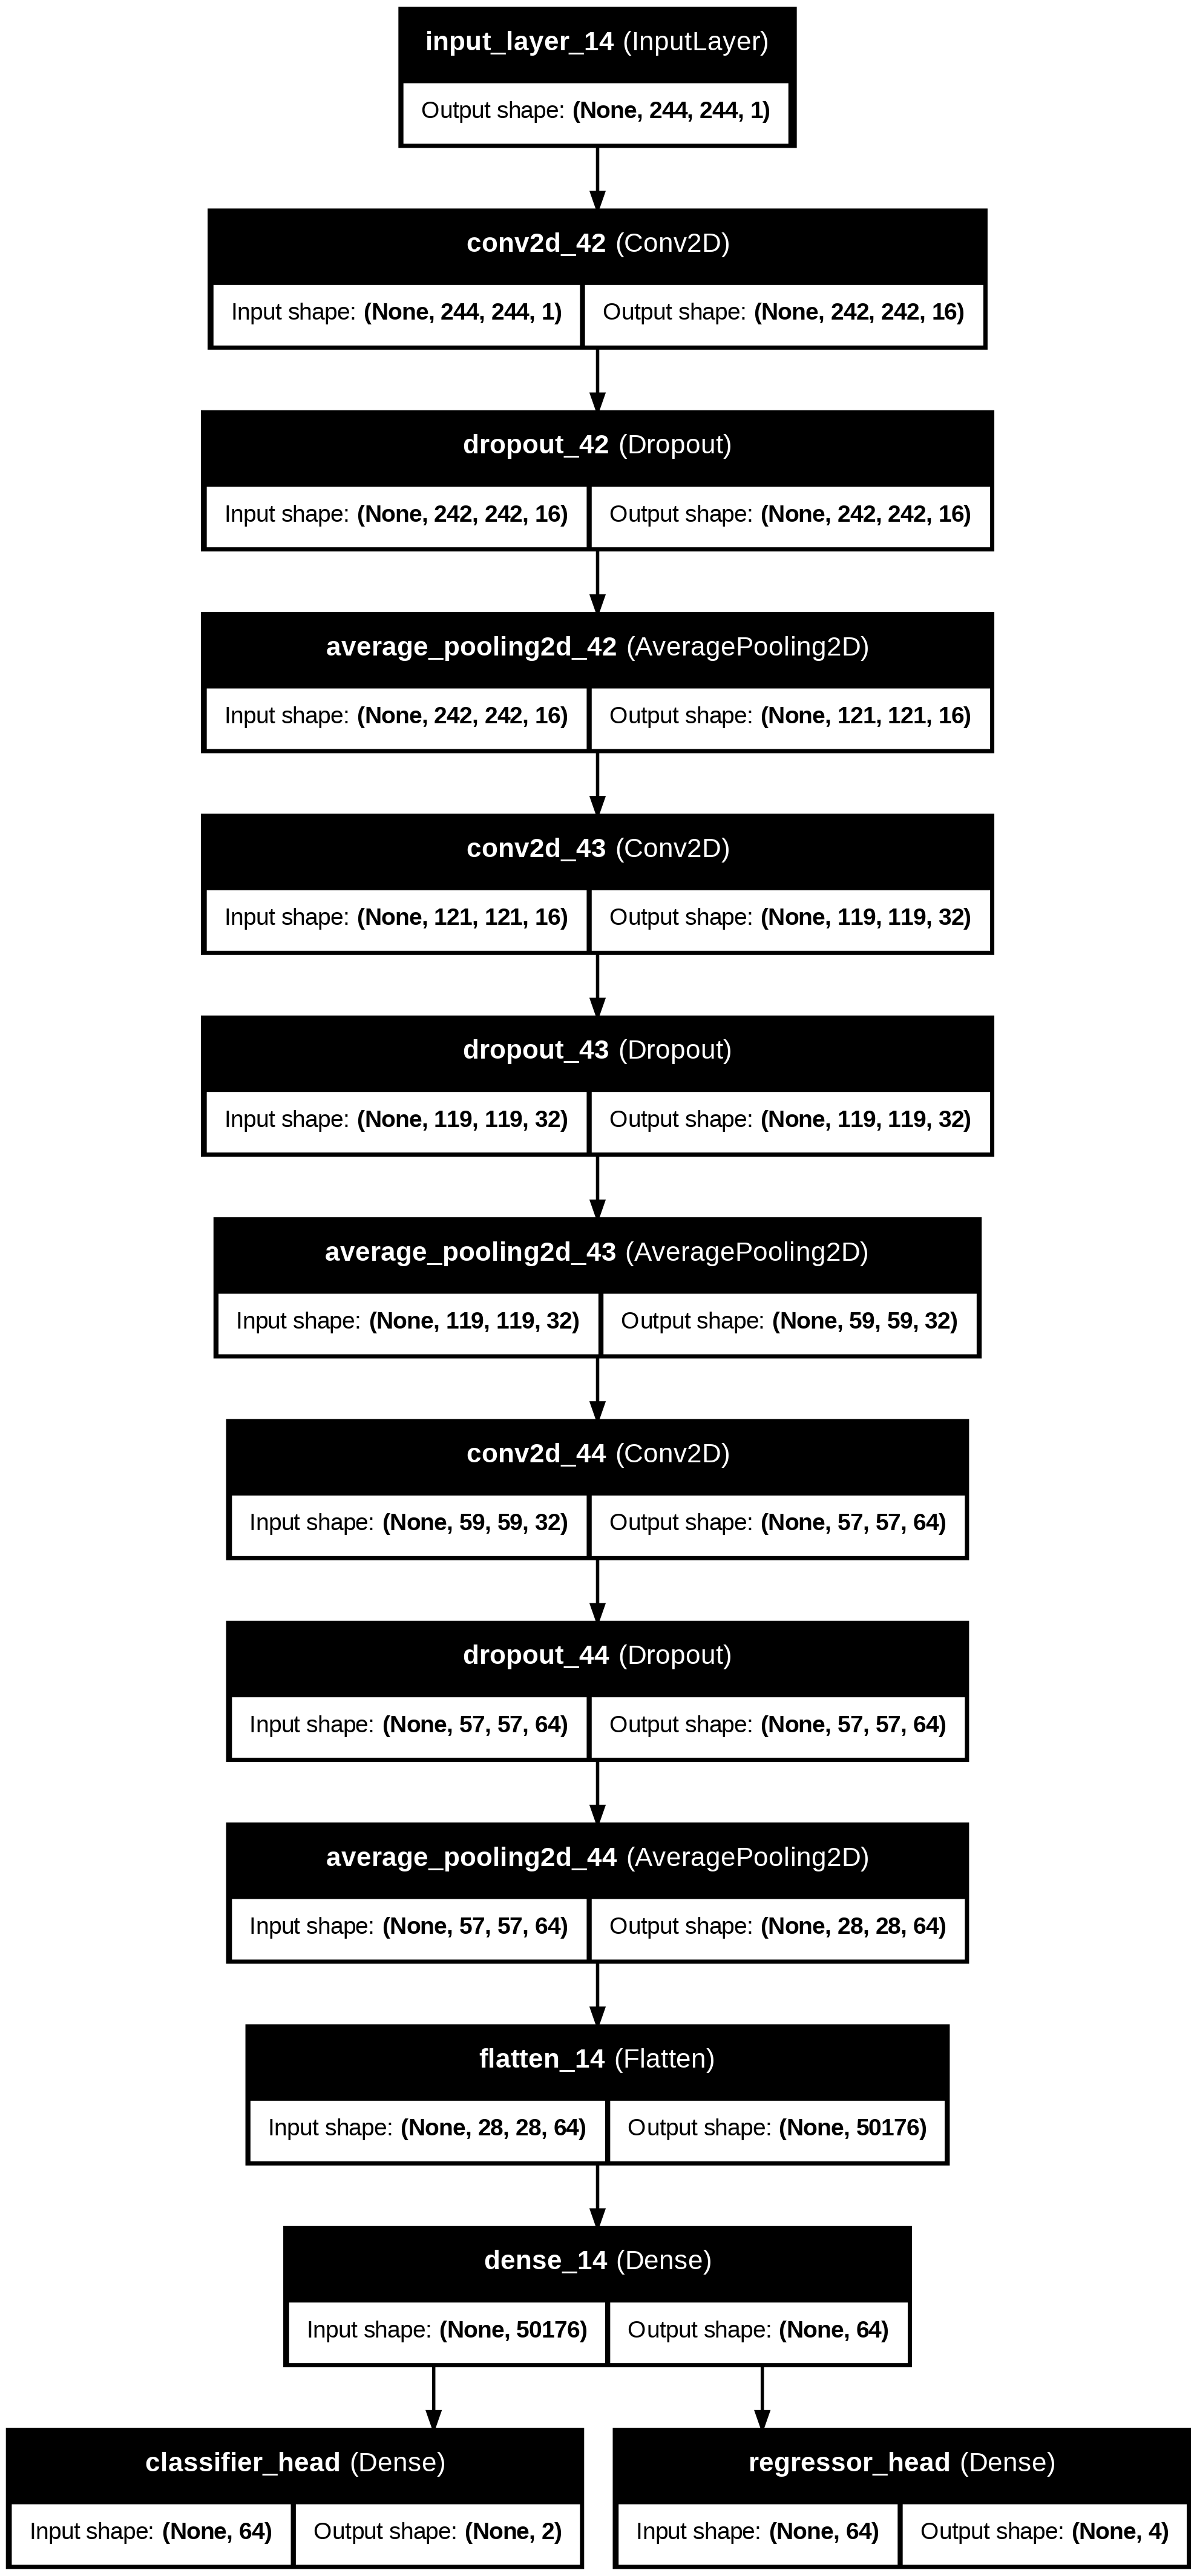

In [113]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [114]:
# EPOCHS = 100

# model = build_model(tf.keras.Input(shape=(input_size, input_size, 1)))
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
# history = model.fit(train_ds,
#                     steps_per_epoch=(len(train_image_files) // BATCH_SIZE),
#                     validation_data=validation_ds, validation_steps=1,
#                     epochs=EPOCHS,
#                     callbacks=[reduce_lr] # Add callback to model.fit
#                     )

In [115]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 1000

model = build_model(tf.keras.Input(shape=(input_size, input_size, 1)))

early_stopping = EarlyStopping(monitor='val_regressor_head_loss', mode='min', patience=100, restore_best_weights=True) # Add EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_regressor_head_loss', mode='min', patience=25, restore_best_weights=True) # Add EarlyStopping callback

history = model.fit(train_ds,
                    steps_per_epoch=(len(train_image_files) // BATCH_SIZE),
                    validation_data=validation_ds,
                    epochs=EPOCHS,
                    callbacks=[early_stopping] # Pass the callback to model.fit
                    )

Epoch 1/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - classifier_head_accuracy: 0.6528 - classifier_head_loss: 4.1977 - loss: 7059.7686 - regressor_head_loss: 7042.5605 - regressor_head_mse: 7042.5605 - val_classifier_head_accuracy: 0.3983 - val_classifier_head_loss: 0.8552 - val_loss: 5407.0845 - val_regressor_head_loss: 5402.8545 - val_regressor_head_mse: 5391.8652
Epoch 2/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - classifier_head_accuracy: 0.7932 - classifier_head_loss: 0.5429 - loss: 4449.3213 - regressor_head_loss: 4435.6138 - regressor_head_mse: 4435.6138 - val_classifier_head_accuracy: 0.3983 - val_classifier_head_loss: 1.8362 - val_loss: 7059.5771 - val_regressor_head_loss: 7166.1494 - val_regressor_head_mse: 7047.4673
Epoch 3/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - classifier_head_accuracy: 0.7856 - classifier_head_loss: 0.5910 - loss: 4347.2085 - regressor_head_loss: 4336.8735 - regressor_head_mse: 4336.8735 - val_classifier_head_accuracy: 0.3983 - val_classifie

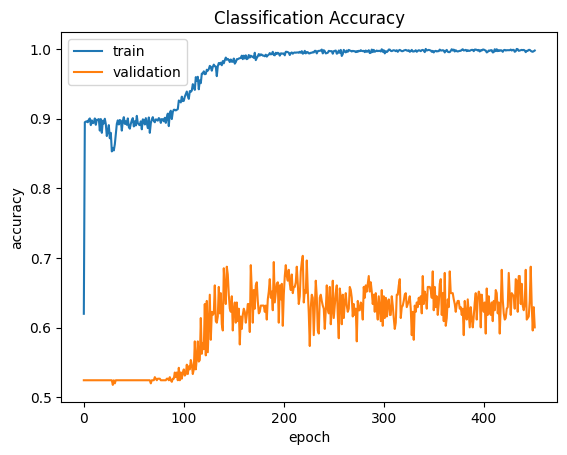

In [96]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Classification Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

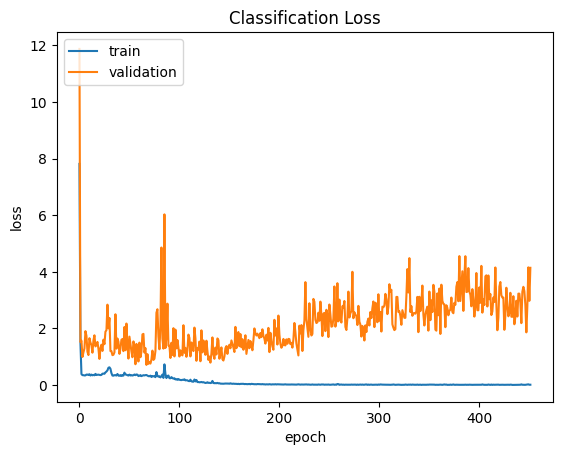

In [97]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

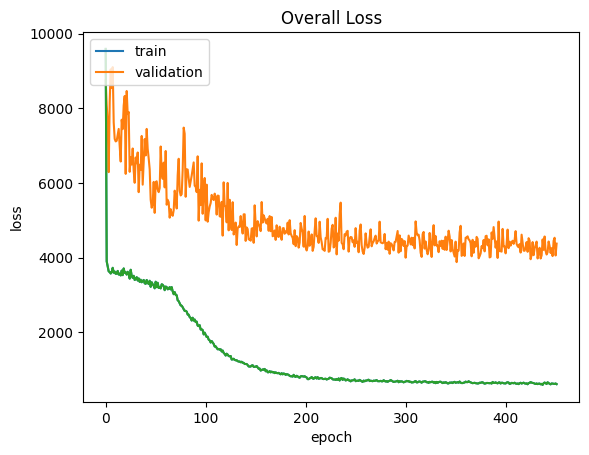

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Overall Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

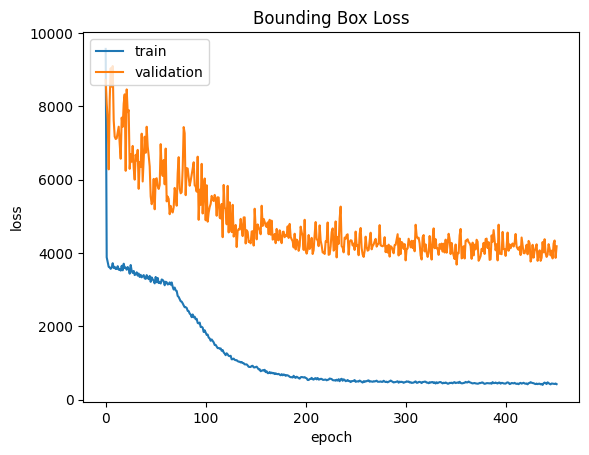

In [99]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

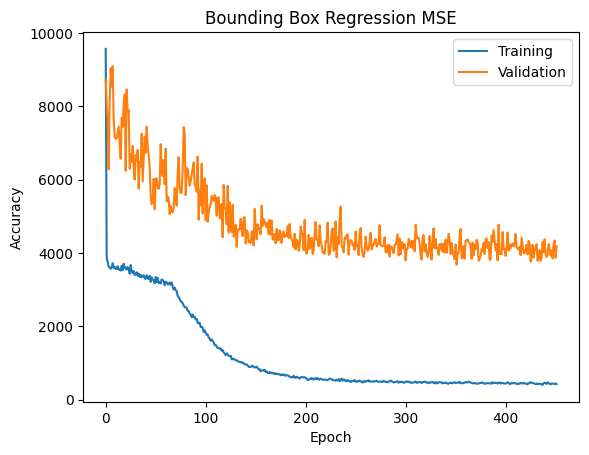

In [100]:
import matplotlib.pyplot as plt

plt.plot(history.history['regressor_head_mse'])
plt.plot(history.history['val_regressor_head_mse'])
plt.title('Bounding Box Regression MSE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## Evaluation

In [116]:
# IoU evaluation

def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1: A NumPy array representing the first bounding box [xmin, ymin, xmax, ymax].
        box2: A NumPy array representing the second bounding box [xmin, ymin, xmax, ymax].

    Returns:
        The IoU value (a float between 0 and 1).
    """
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate the area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

53
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
(244, 244, 1)
Image 0: True Label: 1 Pred Label: 1, True box [117. 141. 173. 181.] Pred box [61.443886 70.552475 87.4607   89.05768 ]
Image 0: IoU: 0.0


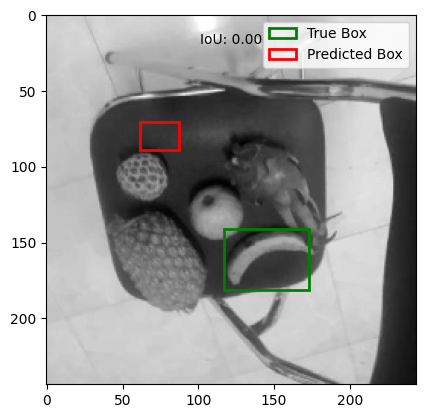

(244, 244, 1)
Image 1: True Label: 1 Pred Label: 1, True box [ 83.  35. 167.  81.] Pred box [ 40.84836   70.65708  113.266594 119.90504 ]
Image 1: IoU: 0.043983012045597396


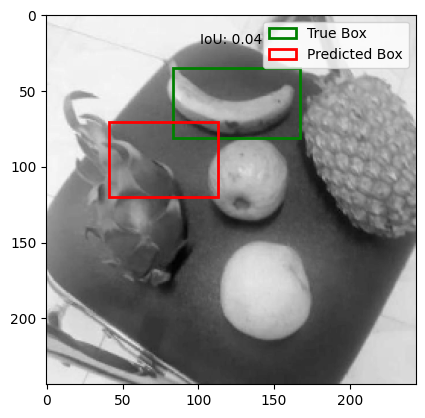

(244, 244, 1)
Image 2: True Label: 1 Pred Label: 1, True box [ 38. 141.  91. 222.] Pred box [ 52.03729 135.52571 109.9233  210.26837]
Image 2: IoU: 0.4558408314223522


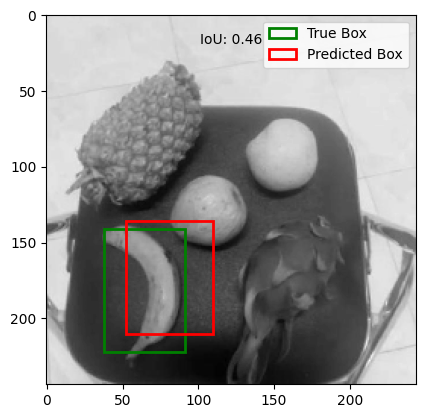

(244, 244, 1)
Image 3: True Label: 1 Pred Label: 1, True box [ 73.  91. 117. 138.] Pred box [36.576836 48.58688  58.927784 64.97185 ]
Image 3: IoU: 0.0


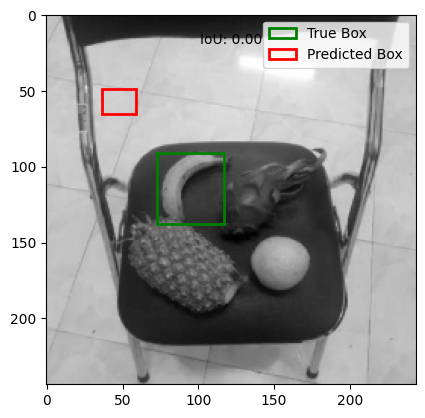

(244, 244, 1)
Image 4: True Label: 1 Pred Label: 1, True box [112.  44. 205.  94.] Pred box [ 74.341125  51.70465  149.74008  105.260765]
Image 4: IoU: 0.2250796417733038


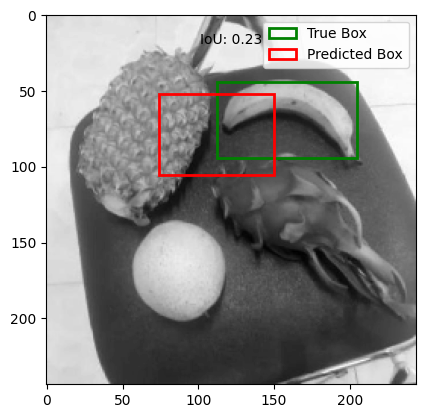

(244, 244, 1)
Image 5: True Label: 0 Pred Label: 0, True box [0. 0. 0. 0.] Pred box [5.2577143 2.9283543 8.197052  5.4036818]
Image 5: IoU: 0.0


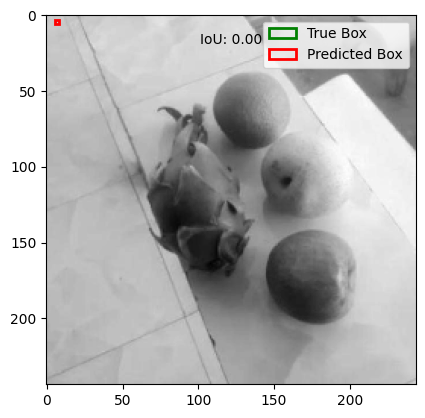

(244, 244, 1)
Image 6: True Label: 1 Pred Label: 1, True box [ 27. 136.  80. 221.] Pred box [ 39.595078 141.60036   96.1419   223.86696 ]
Image 6: IoU: 0.5392933308096184


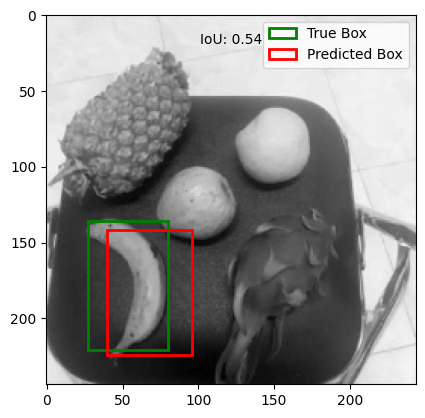

(244, 244, 1)
Image 7: True Label: 0 Pred Label: 1, True box [0. 0. 0. 0.] Pred box [36.129185 46.32339  64.7433   75.86314 ]
Image 7: IoU: 0.0


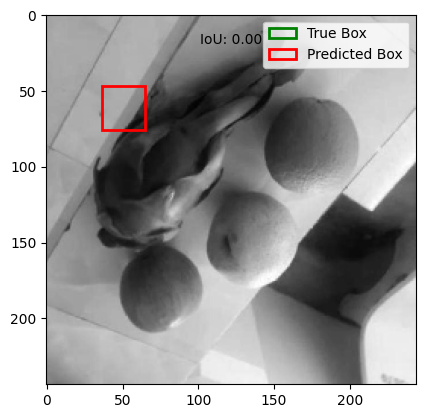

(244, 244, 1)
Image 8: True Label: 1 Pred Label: 1, True box [  8.  67.  55. 139.] Pred box [ 35.652054  98.19282   87.79268  207.13785 ]
Image 8: IoU: 0.09541294797619644


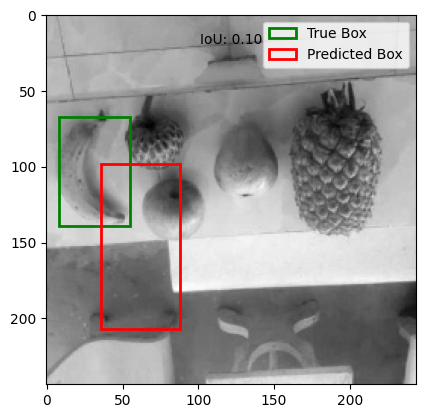

(244, 244, 1)
Image 9: True Label: 1 Pred Label: 1, True box [120.  22. 198. 100.] Pred box [ 73.19442  72.6528  129.99643 107.51188]
Image 9: IoU: 0.035089869626679725


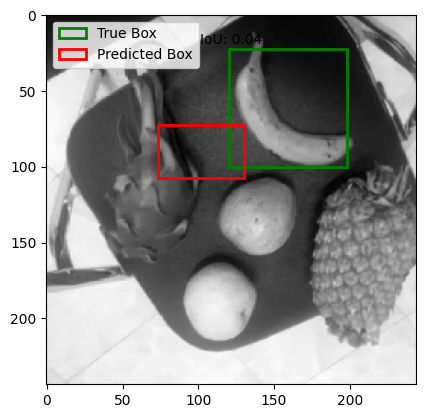

In [117]:
# Predict some examples from the test set

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

for image, (label, box) in test_ds.take(1):  # Get the first batch
    print(len(image))
    # Get predictions
    predictions = model.predict(image)

    # Assuming 'predictions' is a tuple with classification and bounding box
    predicted_labels = predictions[0]
    predicted_boxes = predictions[1]


    for i in range(10): # predict 10 images from the batch
        # Convert image to NumPy array
        print(image[i].numpy().shape)
        img = image[i].numpy()[:, :, 0]

        # Get true values
        true_label = label[i].numpy().argmax()
        true_box = box[i].numpy()

        # Get predicted values
        pred_label = predicted_labels[i].argmax()
        pred_box = predicted_boxes[i]
        print(f"Image {i}: True Label: {true_label} Pred Label: {pred_label}, True box {true_box} Pred box {pred_box}")

        # Create plot
        fig, ax = plt.subplots(1)
        ax.imshow(img, cmap='gray')

        # Add true bounding box
        rect_true = patches.Rectangle((true_box[0], true_box[1]), (true_box[2]-true_box[0]), (true_box[3]-true_box[1]), linewidth=2, edgecolor='g', facecolor='none', label='True Box')
        ax.add_patch(rect_true)

        # Add predicted bounding box
        rect_pred = patches.Rectangle((pred_box[0], pred_box[1]), (pred_box[2]-pred_box[0]), (pred_box[3]-pred_box[1]), linewidth=2, edgecolor='r', facecolor='none', label='Predicted Box')
        ax.add_patch(rect_pred)

        ax.legend()

        # Calculate IoU
        iou = calculate_iou(true_box, pred_box)
        print(f"Image {i}: IoU: {iou}")

        # Add IoU to the plot (optional)
        plt.text(0.5, 0.95, f"IoU: {iou:.2f}", ha='center', va='top', transform=ax.transAxes)  # Position the text

        # Display the plot
        plt.show()